**Rain in Australia dataset:** \

Notebook 4, Model development and evaluation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("./drive/MyDrive/Colab_Notebooks/MLDM_project/")
# os.chdir("./drive/MyDrive/Colab Notebooks")

In [ ]:
print(os.listdir("input_data/"))

['weatherAUS.csv', 'data.csv', 'bankruptcy_train_imbalanced.npy', 'bankruptcy_train.npy', 'bankruptcy_train_train.npy', 'bankruptcy_train_val.npy', 'bankruptcy_test.npy', 'rain_train_train.npy', 'rain_train_val.npy', 'rain_train.npy', 'rain_test.npy']


Installing the required packages

In [ ]:
!pip install tensorflow-addons
!pip install -q -U keras-tuner

     |████████████████████████████████| 686kB 4.0MB/s 


In [ ]:
import pandas as pd
import numpy as np
import random as rn
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
import warnings
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from sklearn import svm
import kerastuner as kt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, plot_confusion_matrix, roc_curve, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc, f1_score, average_precision_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score


warnings.filterwarnings('ignore')

In [ ]:
#Loading data
train_data = np.load('input_data/rain_train.npy')
test_data = np.load('input_data/rain_test.npy')

#Further splitting train_data into training and validation set
train_train_data = np.load('input_data/rain_train_train.npy')
train_val_data = np.load('input_data/rain_train_val.npy')

In [ ]:
X_train = train_data[:,:-1]
y_train = np.reshape(train_data[:,-1], (181732,1))
X_test = test_data[:,:-1]
y_test = test_data[:,-1]

X_train_train = train_train_data[:,:-1]
y_train_train = np.reshape(train_train_data[:,-1], (145384,1))
X_train_val = train_val_data[:,:-1]
y_train_val = np.reshape(train_val_data[:,-1], (23274,1))

Base Model: Logistic Regression

In [ ]:
nb = GaussianNB().fit(X_train, y_train)

### Model: SVM




In [ ]:
svmclassifier = svm.SVC()

In [ ]:
svmclassifier.fit(X_train, y_train)
predicted = svmclassifier.predict(X_test)

In [ ]:
#printing the classification report
print("Classification report for classifier %s:\n%s\n"
      % (svmclassifier, metrics.classification_report(y_test, predicted)))

#plotting the confusion matrix
svm_matx = metrics.plot_confusion_matrix(svmclassifier, X_test, y_test)
svm_matx.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % svm_matx.confusion_matrix)
plt.show()

#### SVM hyper-parameter tuning
only 3 values for C, gamma are taken into consideration for hyperparameter tuning as due to lack of computing power as the datset is very large.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
#defining the parameters for tuning
param_grid = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']} 
  
grid = RandomizedSearchCV(svm.SVC(), param_grid, refit = True, verbose = 1)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print('The best hyper-parameters for SVM: \n',grid.best_params_)

The best hyper parameters using RandomizedSearchCV by fitting 5 folds for each of 9 candidates, totalling 45 fits are 'C': 100, 'gamma': 0.01, 'kernel': 'rbf' 

Testing Accuracy = 0.7399972501031211
ROC Area under Curve for SVM = 0.7243144738174482
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.90      0.75      0.82     22780
         1.0       0.44      0.70      0.54      6312

    accuracy                           0.74     29092
   macro avg       0.67      0.72      0.68     29092
weighted avg       0.80      0.74      0.76     29092

Confusion matrix:
[[17131  5649]
 [ 1915  4397]]


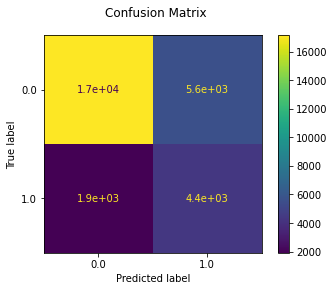

In [ ]:
#fitting the model with the best hyperparameters
#WARNING:the svm model takes 14+ hours to complete running
svm_tuned = svm.SVC(C= 100,gamma= 0.01,kernel= 'rbf', probability=True)
svm_tuned.fit(X_train,y_train)

#model predictions
y_pred = svm_tuned.predict(X_test)

#Printing the accuracy for SVM
acc_svm = accuracy_score(y_test, y_pred)
print("Testing Accuracy = {}".format(acc_svm))

#Printing the AUC for SVM
roc_auc_svm = metrics.roc_auc_score(y_test,y_pred)
print("ROC Area under Curve for SVM = {}".format(roc_auc_svm))

#printing classification report
SVMreport = metrics.classification_report(y_test,y_pred)
print('Classification Report: \n', SVMreport)

#printing the confusion matrix
disp = metrics.plot_confusion_matrix(svm_tuned, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)
plt.show()



### Model: Decision Tree



In [ ]:
Dtree = DecisionTreeClassifier(random_state=20, ccp_alpha = 0.015)
Dtree = Dtree.fit(X_train,y_train)

In [ ]:
# Prediction on the test data
y_pred = Dtree.predict(X_test)

# Accuracy score of the test data

print('Accuracy Score:', metrics.accuracy_score(y_test,y_pred))

Accuracy Score: 0.38776983363123885


Checking different metrics for decision tree model with default hyper parameters:

Training accuracy:  0.7341359804547355
Accuracy = 0.38776983363123885
ROC Area under Curve = 0.7339535790906795
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.93      0.24      0.38     22780
         1.0       0.25      0.93      0.40      6312

    accuracy                           0.39     29092
   macro avg       0.59      0.58      0.39     29092
weighted avg       0.78      0.39      0.38     29092

Confusion matrix:
[[ 5396 17384]
 [  427  5885]]


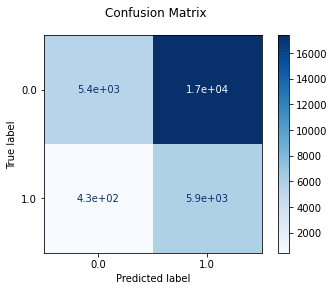

In [ ]:
# Checking different metrics for decision tree model with default hyper parameters

print('Checking different metrics for decision tree model with default hyper parameters:\n')

print("Training accuracy: ", Dtree.score(X_train,y_train))

acc = accuracy_score(y_test, y_pred)
print("Accuracy = {}".format(acc))

roc_auc = roc_auc_score(y_test, Dtree.predict_proba(X_test)[:, 1])
print("ROC Area under Curve = {}".format(roc_auc))

class_report = classification_report(y_test,y_pred)
print('Classification Report: \n', class_report)

cm_plt = metrics.plot_confusion_matrix(Dtree, X_test, y_test, cmap=plt.cm.Blues)
cm_plt.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % cm_plt.confusion_matrix)
plt.show()

#### Decision Tree : Hyper parameter tuning - Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

# Set values for each parameters

max_depth = [5, 10, 15, 25, 30, 35, 40, 45, 50]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10, 15, 20, 25, 30]
max_features = [1, 2, 5, 10, 15, 20, 25, 30]
max_leaf_nodes = [2, 5, 10, 15, 20]

# Creating a dictionary for the hyper parameters

param_grid = dict(max_depth = max_depth, min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf, max_features = max_features, max_leaf_nodes = max_leaf_nodes)


# Applying GridSearchCV to get the best value for hyperparameters

grid_search = GridSearchCV(Dtree, param_grid, cv = 5, verbose = 1, n_jobs = -1)
best_grid = grid_search.fit(X_train, y_train)

# Printing the best hyper parameters

print('The best hyper parameters are: \n', grid_search.best_params_)

**Best Parameters:**

Fitting 5 folds for each of 14400 candidates, totalling 72000 fits

The best hyper parameters are: 

{'max_depth': 35, 'max_features': 30, 'max_leaf_nodes': 20, 'min_samples_leaf': 15, 'min_samples_split': 15}

In [ ]:
# Fitting the decision tree model with the best hyper parameters obtained through GridSearchCV

Dtree_grid_tuned = DecisionTreeClassifier(random_state = 20, ccp_alpha = 0.015, criterion ='entropy', splitter = 'random', max_depth = 35, min_samples_leaf = 15, min_samples_split = 15, max_features = 30, max_leaf_nodes = 20)
Dtree_grid_tuned.fit(X_train,y_train)
y_pred1 = Dtree_grid_tuned.predict(X_test)

Checking different metrics for decision tree model after tuning with the GridSearchCV hyper parameters:

Training accuracy:  0.7195540686285299
Accuracy = 0.7559122782895641
ROC Area under Curve = 0.752328577421548
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.89      0.78      0.83     22780
         1.0       0.46      0.66      0.54      6312

    accuracy                           0.76     29092
   macro avg       0.67      0.72      0.69     29092
weighted avg       0.80      0.76      0.77     29092

Confusion matrix:
[[17855  4925]
 [ 2176  4136]]


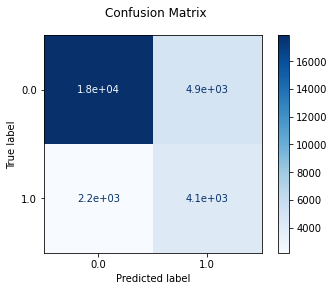

In [ ]:
# Checking different metrics for decision tree model with GridSearchCV hyper parameters

print('Checking different metrics for decision tree model after tuning with the GridSearchCV hyper parameters:\n')

print("Training accuracy: ", Dtree_grid_tuned.score(X_train,y_train))

acc = accuracy_score(y_test, y_pred1)
print("Accuracy = {}".format(acc))

roc_auc = roc_auc_score(y_test, Dtree_grid_tuned.predict_proba(X_test)[:, 1])
print("ROC Area under Curve = {}".format(roc_auc))

class_report = classification_report(y_test, y_pred1)
print('Classification Report: \n', class_report)

cm_plt = metrics.plot_confusion_matrix(Dtree_grid_tuned, X_test, y_test, cmap=plt.cm.Blues)
cm_plt.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % cm_plt.confusion_matrix)
plt.show()


#### Decision Tree: Hyper parameter tuning - Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Set values for each parameters

max_depth = [5, 10, 15, 25, 30, 35, 40, 45, 50]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10, 15, 20, 25, 30]
max_features = [1, 2, 5, 10, 15, 20, 25, 30]
max_leaf_nodes = [2, 5, 10, 15, 20]

# Creating a dictionary for the hyper parameters

param_grid = dict(max_depth = max_depth, min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf, max_features = max_features, max_leaf_nodes = max_leaf_nodes)

# Applying RandomizedSearchCV to get the best value for hyperparameters

rand_search = RandomizedSearchCV(Dtree, param_grid, cv = 5, verbose = 1, n_jobs = -1)
best_grid = rand_search.fit(X_train, y_train)

# Printing the best hyper parameters

print('The best hyper parameters are: \n', rand_search.best_params_)

**Best Parameters:**

Fitting 5 folds for each of 10 candidates, totalling 50 fits

The best hyper parameters are: 

{'min_samples_split': 2, 'min_samples_leaf': 30, 'max_leaf_nodes': 10, 'max_features': 20, 'max_depth': 30}

In [ ]:
# Fitting the decision tree model with the best hyper parameters obtained through RandomizedSearchCV

Dtree_rand_tuned = DecisionTreeClassifier(random_state = 20, ccp_alpha = 0.015, criterion = 'entropy', splitter = 'random', max_depth = 30, min_samples_leaf = 30, min_samples_split = 2, max_features = 20, max_leaf_nodes = 10)
Dtree_rand_tuned.fit(X_train,y_train)
y_pred2 = Dtree_rand_tuned.predict(X_test)

Checking different metrics for decision tree model after tuning with the RandomizedSearchCV hyper parameters:

Training accuracy:  0.7205830563687188
Accuracy = 0.7139763508868417
ROC Area under Curve = 0.7505148679271948
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.91      0.71      0.79     22780
         1.0       0.41      0.74      0.53      6312

    accuracy                           0.71     29092
   macro avg       0.66      0.72      0.66     29092
weighted avg       0.80      0.71      0.74     29092

Confusion matrix:
[[16123  6657]
 [ 1664  4648]]


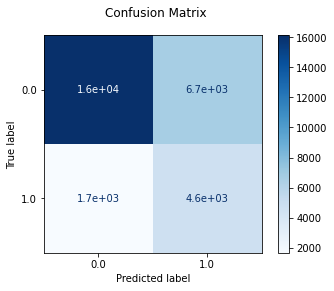

In [ ]:
# Checking different metrics for decision tree model with RandomizedSearchCV hyper parameters

print('Checking different metrics for decision tree model after tuning with the RandomizedSearchCV hyper parameters:\n')

print("Training accuracy: ", Dtree_rand_tuned.score(X_train,y_train))

acc = accuracy_score(y_test, y_pred2)
print("Accuracy = {}".format(acc))

roc_auc = roc_auc_score(y_test, Dtree_rand_tuned.predict_proba(X_test)[:, 1])
print("ROC Area under Curve = {}".format(roc_auc))

class_report = classification_report(y_test, y_pred2)
print('Classification Report: \n', class_report)

cm_plt = metrics.plot_confusion_matrix(Dtree_rand_tuned, X_test, y_test, cmap=plt.cm.Blues)
cm_plt.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % cm_plt.confusion_matrix)
plt.show()

ROC AUC curve before and after tuning hyper parameters:



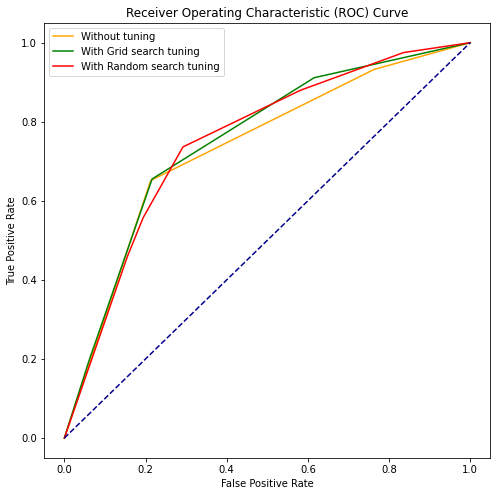

In [ ]:
from matplotlib import pyplot as plt

# Plotting the ROC AUC curve before and after tuning hyper parameters

print('ROC AUC curve before and after tuning hyper parameters:\n')

probs = Dtree.predict_proba(X_test)[:, 1]
probs_grid = Dtree_grid_tuned.predict_proba(X_test)[:, 1]
probs_rand = Dtree_rand_tuned.predict_proba(X_test)[:, 1]
fper, tper, thresholds = roc_curve(y_test, probs) 
fper1, tper1, thresholds1 = roc_curve(y_test, probs_grid) 
fper2, tper2, thresholds2 = roc_curve(y_test, probs_rand) 

plt.figure(figsize=(8, 8))
plt.plot(fper, tper, color='orange', label='Without tuning')
plt.plot(fper1, tper1, color='green', label='With Grid search tuning')
plt.plot(fper2, tper2, color='red', label='With Random search tuning')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
X_test.shape

(29092, 118)

### Model: DNN

#### DNN: Hyperparameter Tuning

Neurons in Hidden layer 1 : {20, 30, 40, 50} </br>
Neurons in Hidden layer 2 : {10, 20, 30, 40, 50} </br>
Dropout rate after Hidden layer 1 : {0.0, 0.1, 0.2, 0.3, 0.4, 0.5} </br>
Dropout rate after Hidden layer 2 : {0.0, 0.1, 0.2, 0.3, 0.4, 0.5} </br>
L1 regularizer : {1e-4, 1e-5, 1e-6, 1e-7, 1e-8} </br>
L2 regularizer : {1e-4, 1e-5, 1e-6, 1e-7, 1e-8} </br>
Optimizer: {'Adam', 'Nadam', 'Adamax', 'Adagrad'}

In [ ]:
def create_model(hp):
  hp_dropout_rates_1 = hp.Choice('Dropout_rate_1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
  hp_dropout_rates_2 = hp.Choice('Dropout_rate_2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
  hp_l1_reg = hp.Choice('L1_penalty', values=[1e-4, 1e-5, 1e-6, 1e-7, 1e-8])
  hp_l2_reg = hp.Choice('L2_penalty', values=[1e-4, 1e-5, 1e-6, 1e-7, 1e-8])
  hp_hidden_neurons_1 = hp.Choice('hidden_neurons', values=[40, 60, 80, 100])
  hp_hidden_neurons_2 = hp.Choice('hidden_neurons', values=[40, 60, 80, 100])

  model = keras.Sequential([
      keras.layers.Dense(118, activation='relu', input_dim=118),
      keras.layers.Dense(hp_hidden_neurons_1, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=hp_l1_reg, l2=hp_l2_reg)),
      keras.layers.Dropout(rate=hp_dropout_rates_1),
      keras.layers.Dense(hp_hidden_neurons_2, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=hp_l1_reg, l2=hp_l2_reg)),
      keras.layers.Dropout(rate=hp_dropout_rates_2),
      keras.layers.Dense(1)
  ])

  hp_optimizer = hp.Choice('Optimizer', values=['Adam', 'Nadam', 'Adamax', 'Adagrad'])

  model.compile(optimizer=hp_optimizer,
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tfa.metrics.F1Score(num_classes=1, average='macro', name='macro_f1'),
                         keras.metrics.BinaryAccuracy()])
  
  return model

In [ ]:
tuner = kt.Hyperband(create_model,
                     objective=kt.Objective("val_macro_f1", direction="max"),
                     max_epochs=10,
                     factor=3)
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_macro_f1", patience=2)

In [ ]:
tuner.search(x=X_train_train, 
             y=y_train_train, 
             validation_data=(X_train_val, y_train_val), 
             callbacks=[stop_early])

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
for key in best_hps.values:
  print('best', key, ': ', best_hps.values[key])

best Dropout_rate_1 :  0.0
best Dropout_rate_2 :  0.2
best L1_penalty :  1e-08
best L2_penalty :  1e-07
best hidden_neurons_1 :  80
best hidden_neurons_2 :  40
best Optimizer :  Adam
best tuner/epochs :  2
best tuner/initial_epoch :  0
best tuner/bracket :  6
best tuner/round :  0


#### DNN: Best Model

In [ ]:
def create_model():
  # Define the structure of the model
  model = keras.Sequential([
      # FC layers
      keras.layers.Dense(118, activation='relu', input_dim=118),
      keras.layers.Dropout(rate=0.0),
      keras.layers.Dense(80, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-8, l2=1e-7)),
      keras.layers.Dense(40, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-8, l2=1e-7)),
      keras.layers.Dropout(rate=0.2),

      # Output layer
      keras.layers.Dense(1, activation='sigmoid')
  ], name = "DNN_model")

  # Assigning optimizer, loss function and evaluation metrices
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tf.metrics.BinaryAccuracy(),
                         tfa.metrics.F1Score(num_classes=1, average='macro', name='macro_f1')])
  
  return model

In [ ]:
tf.random.set_seed(3)
rn.seed(3)
dnn = create_model()
dnn.summary()

Model: "DNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 118)               14042     
_________________________________________________________________
dropout (Dropout)            (None, 118)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                9520      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 26,843
Trainable params: 26,843
Non-trainable params: 0
_____________________________________________________

In [ ]:
# Parameters
epochs = 30

# Training the model
dnn.fit(X_train, 
        y_train, 
        epochs = epochs,
        verbose = 0,
        validation_data = (X_test, y_test))

In [ ]:
# Results with training data
y_pred_train = [[round(num) for num in row] for row in dnn.predict(X_train)]
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

[[89721  1145]
 [90177   689]]
              precision    recall  f1-score   support

         0.0       0.50      0.99      0.66     90866
         1.0       0.38      0.01      0.01     90866

    accuracy                           0.50    181732
   macro avg       0.44      0.50      0.34    181732
weighted avg       0.44      0.50      0.34    181732



In [ ]:
# Results with testing data
y_pred = [[round(num) for num in row] for row in dnn.predict(X_test)]
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[22518   262]
 [ 6259    53]]
              precision    recall  f1-score   support

         0.0       0.78      0.99      0.87     22780
         1.0       0.17      0.01      0.02      6312

    accuracy                           0.78     29092
   macro avg       0.48      0.50      0.44     29092
weighted avg       0.65      0.78      0.69     29092



### Experiment 2: Comparing algorithms' performances in datasets with different sizes

In [ ]:
models = [nb, Dtree_grid_tuned, svm_tuned, dnn]
model_names = ["Base model", "DT", "SVM", "DNN"]

#### Functions for comparison

In [ ]:
def eval_metrics_table(model_list,model_names):
    Models_cols = []
    Models_compare = pd.DataFrame(columns = Models_cols)
    row_index = 0
    for i in range(len(models)):
        if model_names[i][:3] == "DNN":
            y_pred = [[round(num) for num in row] for row in model_list[i].predict(X_test)]
            y_pred_prob = model_list[i].predict(X_test).ravel()
        else:
            y_pred = model_list[i].predict(X_test).ravel()
            y_pred_prob = model_list[i].predict_proba(X_test)[:,1]
    
        fpr, tpr, thresh = roc_curve(y_test, y_pred)
        Models_name = model_names[i]
        Models_compare.loc[row_index,'Model used'] = Models_name
        Models_compare.loc[row_index, 'Test Accuracy'] = accuracy_score(y_test, y_pred)
        Models_compare.loc[row_index, 'F1 score'] = f1_score(y_test, y_pred, average='macro')
        Models_compare.loc[row_index, 'Precision'] = precision_score(y_test, y_pred)
        Models_compare.loc[row_index, 'Recall'] = recall_score(y_test, y_pred)
        Models_compare.loc[row_index, 'ROC AUC'] = roc_auc_score(y_test, y_pred_prob)
        Models_compare.loc[row_index, 'Precision-recall AUC'] = average_precision_score(y_test, y_pred_prob)

        row_index+=1
    
    #Models_compare.sort_values(by = ['F1 score'], ascending = False, inplace = True)  
    Models_compare.reset_index(inplace = True, drop=True)  
    return Models_compare

In [ ]:
eval_metrics_table(models,model_names)

,Model used,Test Accuracy,F1 score,Precision,Recall,ROC AUC,Precision-recall AUC
0,Base model,0.597071,0.564518,0.318905,0.73851,0.708752,0.428837
1,DT,0.75739,0.68836,0.462161,0.654275,0.749524,0.400432
2,SVM,0.748036,0.701623,0.529408,0.632500,0.802215,0.589524
3,DNN,0.804001,0.725916,0.546808,0.616627,0.828973,0.606998
